# Problem Description
The problem is to create a generative model to convert photos into Monet style paintings. The training data consists of 300 Monet paintings and 7038 photos.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image
import torchvision.models as models
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
import itertools
import time
import shutil
from pathlib import Path
from torch.amp import autocast, GradScaler

# access folders
path_monet = "../input/gan-getting-started/monet_jpg/"
path_photo = "../input/gan-getting-started/photo_jpg/"

print("Number of monet paintings: {}".format(len(os.listdir(path_monet))))
print("Number of photos: {}".format(len(os.listdir(path_photo))))

Number of monet paintings: 300
Number of photos: 7038


In [2]:
# function to display sample images in a grid format
def display_sample_images(path, num_samples=16, figsize = (15, 15)):
    sample_images = os.listdir(path)[:num_samples]
    
    w = int(num_samples ** .5)
    h = math.ceil(num_samples / w)

    plt.figure(figsize = figsize)
    
    for ind, image_name in enumerate(sample_images):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

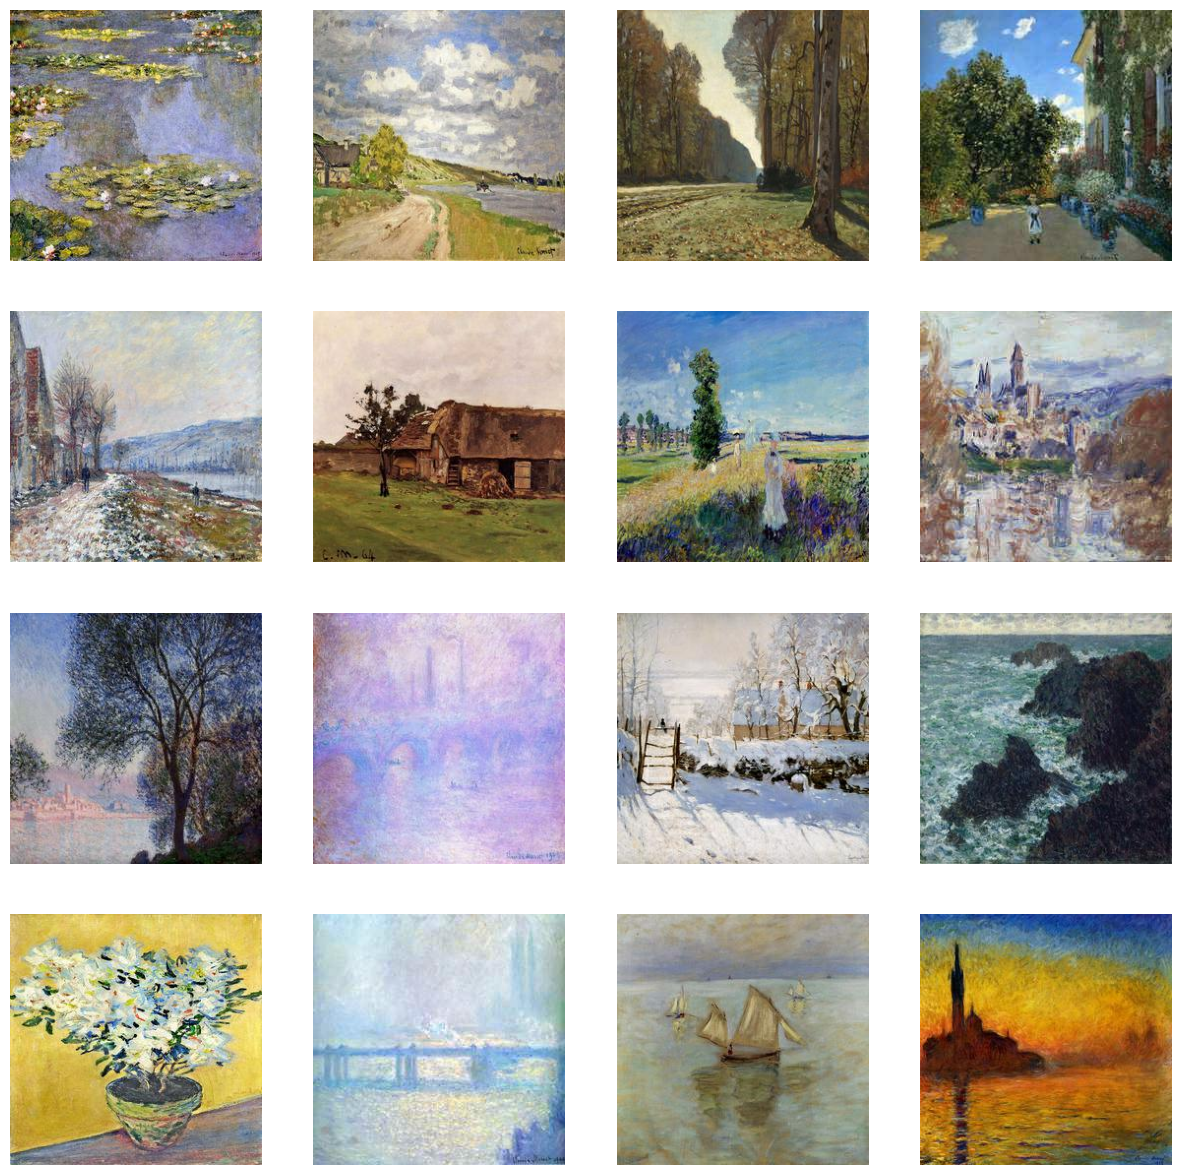

In [3]:
display_sample_images(path_monet)

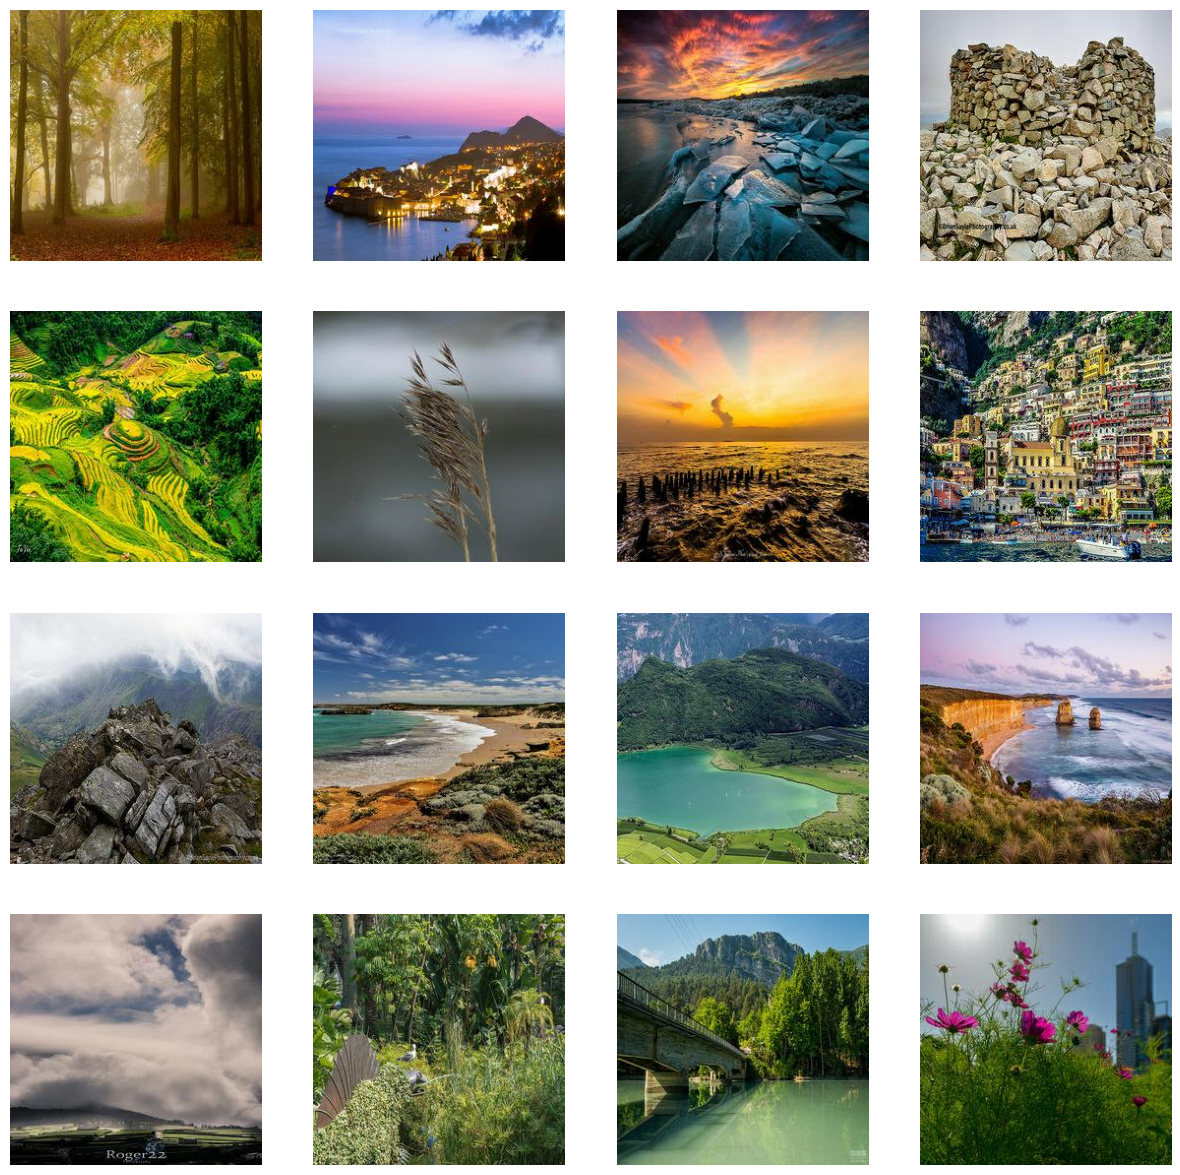

In [4]:
display_sample_images(path_photo)

# Exploratory Data Analysis

In [5]:
monet_files = os.listdir(path_monet)
photo_files = os.listdir(path_photo)

monet_lens = []
monet_widths = []
photo_lens = []
photo_widths = []

for i in monet_files:
    img = Image.open(path_monet + i)
    w, l = img.size 
    if w not in monet_widths:
        monet_widths = monet_widths + [w]
    if l not in monet_lens:
        monet_lens = monet_lens + [l]

for i in photo_files:
    img = Image.open(path_photo + i)
    w, l = img.size 
    if w not in photo_widths:
        photo_widths = photo_widths + [w]
    if l not in photo_lens:
        photo_lens = photo_lens + [l]

print("Monet Lengths: ", monet_lens)
print("Monet Widths: ", monet_widths)
print("Photo Lengths: ", photo_lens)
print("Photo Widths: ", photo_widths)

Monet Lengths:  [256]
Monet Widths:  [256]
Photo Lengths:  [256]
Photo Widths:  [256]


Checking the length and widths of all the pictures, we can see that all images are the same size of 256x256. 

In [6]:
def get_color_dist(path):
    r_list = []
    g_list = []
    b_list = []

    pics = os.listdir(path)
    for i in pics:
        img = Image.open(path + i)
        img = np.array(img)
        r, g, b = np.sum(img, axis = (0, 1))
        r_list = r_list + [r]
        g_list = g_list + [g]
        b_list = b_list + [b]
    return r_list, g_list, b_list

monet_r, monet_g, monet_b = get_color_dist(path_monet)
photo_r, photo_g, photo_b = get_color_dist(path_photo)

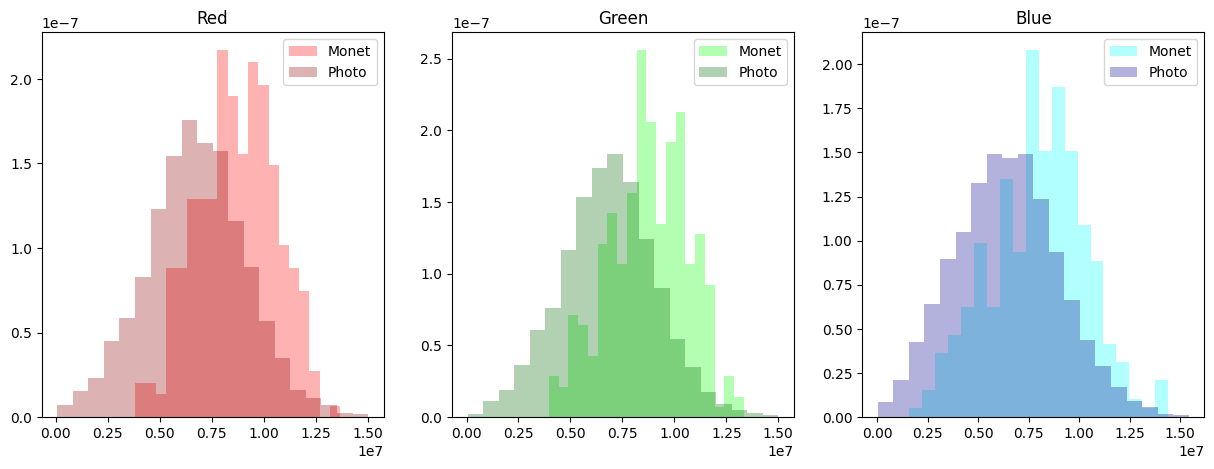

In [7]:
plt.figure(figsize=(15, 5))

# Red distribution comparison
plt.subplot(1, 3, 1)
plt.hist(monet_r, bins=20, density=True, color='red', alpha=0.3, label='Monet')
plt.hist(photo_r, bins=20, density=True, color='darkred', alpha=0.3, label='Photo')
plt.legend()
plt.title('Red')

# Green distribution comparison
plt.subplot(1, 3, 2)
plt.hist(monet_g, bins=20, density=True, color='lime', alpha=0.3, label='Monet')
plt.hist(photo_g, bins=20, density=True, color='darkgreen', alpha=0.3, label='Photo')
plt.legend()
plt.title('Green')

# Blue distribution comparison
plt.subplot(1, 3, 3)
plt.hist(monet_b, bins=20, density=True, color='cyan', alpha=0.3, label='Monet')
plt.hist(photo_b, bins=20, density=True, color='darkblue', alpha=0.3, label='Photo')
plt.legend()
plt.title('Blue')

plt.show()

Checking the color distributions of the Monet images vs the photos, we can see that the Monet images tend to have a shifted distribution, or brighter colors. 

The mean and standard deviations of the color distributions is shown below. 

In [8]:
avg_monet_r = np.mean(monet_r)
avg_monet_g = np.mean(monet_g)
avg_monet_b = np.mean(monet_b)
std_monet_r = np.std(monet_r)
std_monet_g = np.std(monet_g)
std_monet_b = np.std(monet_b)

avg_photo_r = np.mean(photo_r)
avg_photo_g = np.mean(photo_g)
avg_photo_b = np.mean(photo_b)
std_photo_r = np.std(photo_r)
std_photo_g = np.std(photo_g)
std_photo_b = np.std(photo_b)



df = pd.DataFrame([[avg_monet_r, avg_photo_r],
                   [avg_monet_g, avg_photo_g],
                   [avg_monet_b, avg_photo_b],
                   [std_monet_r, std_photo_r],
                   [std_monet_g, std_photo_g],
                   [std_monet_b, std_photo_b]],
                  columns=['Monet', 'Photo'], index = ['Avg Red', 'Avg Green', 'Avg Blue', 'Std Red', 'Std Green', 'Std Blue'])

df = df / 1000000
df.style.format('{:.2f}')

# Model

The model for this will be a cycle GAN. How it works is there will be 2 generators and 2 discriminators, one for generating Monet paintings from photos, and one for generating photos from Monet paintings. The 2 discriminators will discriminate between Monet and photos. 

The training cycle is shown below:

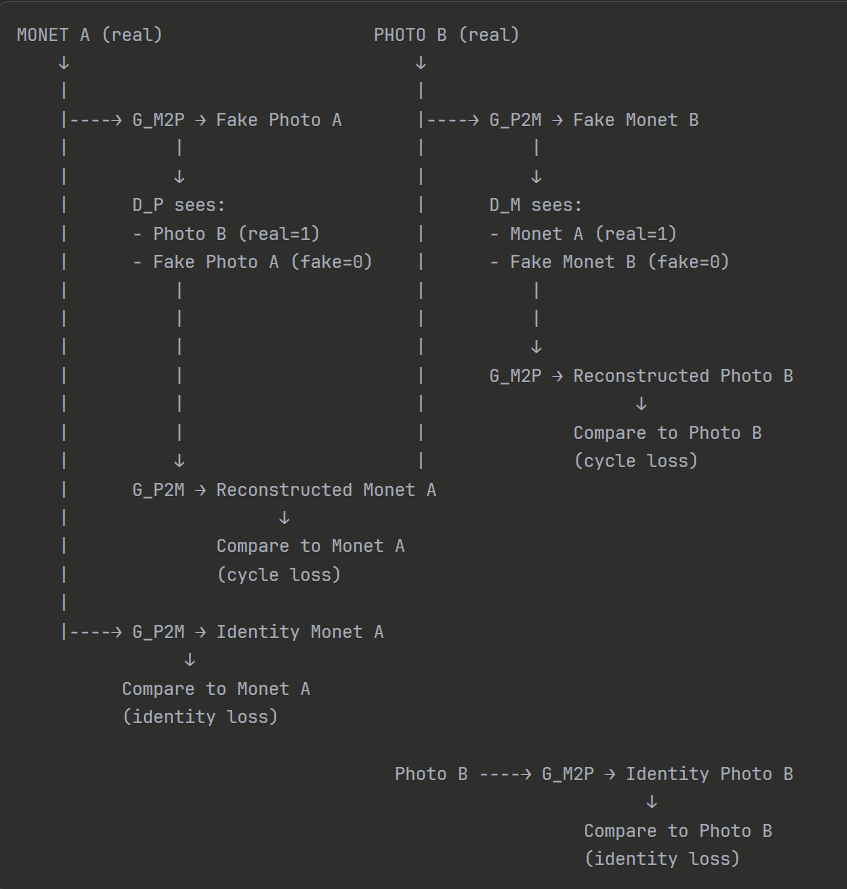

The reason for the cycle structure with 2 generators and 2 discriminators is so the generator preserves the original photo and learns to only translate the style. 

Each generator gets gradients from 4 sources:
- Discriminator for the M2P or P2M conversion
- Cycle (From the other generator. For example, if P2M generates a Monet that M2P cannot convert back well, it is penalized for it)
- Cycle (From itself when it converts a photo or Monet back to its original
- Identity, where a photo or Monet shouldn't be converted.

Each discriminator gets gradients from 2 sources
- Classifying the real Monet or photo correctly
- Classifying the fake Monet or photo correctly

## Generator Structure
For the generator, I will use an encoder/decoder structure with 3 CNN each. The encoder captures features while the decoder reconstructs them in the translated style. Reflection padding is used to avoid border artifacts and instance norm is used for regularization to help normalize image differences such as brightness/contrast. Average pooling is used to reduce dimensions while each convolution layer creates deeper features. A residual block is used to convert the picture's style after it gets the features from the convolution layers, as the skip connection ensures only the style is changed while the image's structure is preserved. A decoder that is the opposite of the encoder is then used to reconstruct the image after the residual block. 

In [1]:
# class ResidualBlock(nn.Module):
#     """
#     Residual block with skip connection: output = input + transformation(input)
    
#     Architecture: Conv -> Norm -> ReLU -> Conv -> Norm, then add to input
#     """
#     def __init__(self, channels):
#         super().__init__()
#         layers = [
#             nn.ReflectionPad2d(1),  # Mirror padding prevents border artifacts
#             nn.Conv2d(channels, channels, 3, stride=1, padding=0),
#             nn.InstanceNorm2d(channels),  # InstanceNorm works better than BatchNorm for style transfer
#             nn.ReLU(inplace=True),  # ReLU is standard for ResNets 
#         ]
        
#         layers.extend([
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(channels, channels, 3, stride=1, padding=0),
#             nn.InstanceNorm2d(channels),
#             # No activation here - will be added to input first
#         ])
        
#         self.block = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return x + self.block(x)  # Skip connection: add input to transformed output


# class Generator(nn.Module):
#     """
#     CycleGAN Generator: Encoder-ResNet-Decoder architecture
    
#     Architecture:
#     - Encoder: 3 downsampling blocks (256->128->64->32)
#     - Bottleneck: residual blocks at 32x32 resolution
#     - Decoder: 3 upsampling blocks (32->64->128->256)
    
#     Why this architecture:
#     - Downsampling captures high-level style features
#     - ResNet bottleneck transforms features while preserving information
#     - Upsampling reconstructs image with new style
#     """
#     def __init__(self, num_residual_blocks=6):
#         super().__init__()
        
#         # Encoder: Downsample to capture features
#         # Use 1, 4, or 16 for batch_size depending on GPU memory
#         encoder = [
#             # Encoder Block 1: 256x256x3 -> 128x128x64
#             nn.ReflectionPad2d(1),  # Pad by mirroring to avoid border artifacts
#             nn.Conv2d(3, 64, 3, stride=1, padding=0),  # Use padding=0 with ReflectionPad
#             nn.InstanceNorm2d(64),  # Normalize each image independently (better for style transfer)
#             nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU allows small negative gradients
#             nn.AvgPool2d(2),  # Downsample: 256 -> 128
            
#             # Encoder Block 2: 128x128x64 -> 64x64x128
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(64, 128, 3, stride=1, padding=0),
#             nn.InstanceNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),  # Downsample: 128 -> 64
            
#             # Encoder Block 3: 64x64x128 -> 32x32x256
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(128, 256, 3, stride=1, padding=0),
#             nn.InstanceNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),  # Downsample: 64 -> 32
#         ]
        
#         # Bottleneck: Transform features while preserving information via skip connections
#         # 6 blocks is standard, use 9 for more complex transformations
#         residual = [ResidualBlock(256) for _ in range(num_residual_blocks)]
        
#         # Decoder: Upsample to reconstruct image
#         decoder = [
#             # Decoder Block 1: 32x32x256 -> 64x64x128
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample: 32 -> 64
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(256, 128, 3, stride=1, padding=0),
#             nn.InstanceNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             # Decoder Block 2: 64x64x128 -> 128x128x64
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample: 64 -> 128
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(128, 64, 3, stride=1, padding=0),
#             nn.InstanceNorm2d(64),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             # Decoder Block 3: 128x128x64 -> 256x256x3
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample: 128 -> 256
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(64, 3, 3, stride=1, padding=0),
#             nn.Tanh()  # Output range [-1, 1] to match normalized input images
#         ]
        
#         # Combine all parts into sequential model
#         self.model = nn.Sequential(*encoder, *residual, *decoder)
    
#     def forward(self, x):
#         return self.model(x)


## Discriminator Structure
I tried various discriminators of varying strengths. Their structures are similar to the generator, with convolution layers and average pooling. Batch normalization was used instead of instance normalization since the discriminator is trying to learn the difference between photos and Monets, so it wants batch-level statistics. The convolution layers learn deep features, and are then flattened to produce an output grid to give the generator more localized feedback. This is better for style transfer as it better captures local patterns instead of the image overall. 

I first started with a discriminator with 5 convolution layers and moved onto weaker discriminators by adding dropout and removing layers. 

In [ ]:
# class Discriminator(nn.Module):
#     """
#     PatchGAN Discriminator: Classifies whether image patches are real or fake
    
#     Why PatchGAN: Instead of classifying the entire image as real/fake, this
#     discriminator outputs a grid (13x13) where each value represents whether
#     that local patch is real or fake. This encourages high-frequency detail
#     and works better for style transfer than a single output.
    
#     Architecture: 5 convolutional blocks with progressively more channels
#     Output: 13x13x1 (each value is probability that patch is real)
#     """
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             # CNN 1: 256x256x3 -> 128x128x64
#             nn.Conv2d(3, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64),  # BatchNorm for discriminator (InstanceNorm for generator)
#             nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU prevents dead neurons
#             nn.AvgPool2d(2),  # Downsample
            
#             # CNN 2: 128x128x64 -> 64x64x128
#             nn.Conv2d(64, 128, 3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),
            
#             # CNN 3: 64x64x128 -> 32x32x256
#             nn.Conv2d(128, 256, 3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),
            
#             # CNN 4: 32x32x256 -> 16x16x512
#             nn.Conv2d(256, 512, 4, stride=2, padding=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             # CNN 5: 16x16x512 -> 13x13x1
#             # Output is a grid of real/fake predictions for different image patches
#             nn.Conv2d(512, 1, 4, stride=1, padding=0),
#             nn.Sigmoid()  # Sigmoid maps output to [0,1] probability
#         )
    
#     def forward(self, x):
#         return self.model(x)


# class Discriminator(nn.Module):
#     """
#     PatchGAN Discriminator: Classifies whether image patches are real or fake
    
#     Why PatchGAN: Instead of classifying the entire image as real/fake, this
#     discriminator outputs a grid (13x13) where each value represents whether
#     that local patch is real or fake. This encourages high-frequency detail
#     and works better for style transfer than a single output.
    
#     Architecture: 5 convolutional blocks with progressively more channels
#     Output: 13x13x1 (each value is probability that patch is real)
#     """
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             # CNN 1: 256x256x3 -> 128x128x64
#             nn.Conv2d(3, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64),  # BatchNorm for discriminator (InstanceNorm for generator)
#             nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU prevents dead neurons
#             nn.AvgPool2d(2),  # Downsample
            
#             # CNN 2: 128x128x64 -> 64x64x128
#             nn.Conv2d(64, 128, 3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),
            
#             # CNN 3: 64x64x128 -> 32x32x256
#             nn.Conv2d(128, 256, 3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),
            
#             # CNN 4: 32x32x256 -> 16x16x512
#             nn.Conv2d(256, 512, 4, stride=2, padding=1),
#             nn.BatchNorm2d(512),
#             nn.Dropout2d(0.5), 
#             nn.LeakyReLU(0.2, inplace=True),
            
#             # CNN 5: 16x16x512 -> 13x13x1
#             # Output is a grid of real/fake predictions for different image patches
#             nn.Conv2d(512, 1, 4, stride=1, padding=0),
#             nn.Sigmoid()  # Sigmoid maps output to [0,1] probability
#         )
    
#     def forward(self, x):
#         return self.model(x)

# class Discriminator(nn.Module):
#     """
#     PatchGAN Discriminator: Classifies whether image patches are real or fake
    
#     Why PatchGAN: Instead of classifying the entire image as real/fake, this
#     discriminator outputs a grid (29x29) where each value represents whether
#     that local patch is real or fake. This encourages high-frequency detail
#     and works better for style transfer than a single output.
    
#     Architecture: 5 convolutional blocks with progressively more channels
#     Output: 13x13x1 (each value is probability that patch is real)
#     """
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             # CNN 1: 256x256x3 -> 128x128x64
#             nn.Conv2d(3, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64),  # BatchNorm for discriminator (InstanceNorm for generator)
#             nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU prevents dead neurons
#             nn.AvgPool2d(2),  # Downsample
            
#             # CNN 2: 128x128x64 -> 64x64x128
#             nn.Conv2d(64, 128, 3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),
            
#             # CNN 3: 64x64x128 -> 32x32x256
#             nn.Conv2d(128, 256, 3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),
            
#             # CNN 4: 32x32x256 -> 29x29x1
#             # Output is a grid of real/fake predictions for different image patches
#             nn.Conv2d(256, 1, 4, stride=1, padding=0),
#             nn.Sigmoid()  # Sigmoid maps output to [0,1] probability
#         )
    
#     def forward(self, x):
#         return self.model(x)

# class Discriminator(nn.Module):
#     """
#     PatchGAN Discriminator: Classifies whether image patches are real or fake
    
#     Why PatchGAN: Instead of classifying the entire image as real/fake, this
#     discriminator outputs a grid (29x29) where each value represents whether
#     that local patch is real or fake. This encourages high-frequency detail
#     and works better for style transfer than a single output.
    
#     Architecture: 5 convolutional blocks with progressively more channels
#     Output: 13x13x1 (each value is probability that patch is real)
#     """
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             # CNN 1: 256x256x3 -> 128x128x64
#             nn.Conv2d(3, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64),  # BatchNorm for discriminator (InstanceNorm for generator)
#             nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU prevents dead neurons
#             nn.AvgPool2d(2),  # Downsample
            
#             # CNN 2: 128x128x64 -> 64x64x128
#             nn.Conv2d(64, 128, 3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.Dropout2d(0.5),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),
            
#             # CNN 3: 64x64x128 -> 32x32x256
#             nn.Conv2d(128, 256, 3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.Dropout2d(0.5),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.AvgPool2d(2),
            
#             # CNN 4: 32x32x256 -> 29x29x1
#             # Output is a grid of real/fake predictions for different image patches
#             nn.Conv2d(256, 1, 4, stride=1, padding=0),
#             nn.Sigmoid()  # Sigmoid maps output to [0,1] probability
#         )
    
#     def forward(self, x):
#         return self.model(x)

In [ ]:
# class ImageDataset(Dataset):
#     """
#     Dataset for CycleGAN training
    
#     Returns random pairs of photos and Monet paintings for unpaired training.
#     Each batch gets random photo-Monet pairs since we don't need matching pairs.
#     """
#     def __init__(self, path_monet, path_photo, size=(256, 256)):
#         super().__init__()
#         self.monet_files = sorted(Path(path_monet).glob('*.jpg'))
#         self.photo_files = sorted(Path(path_photo).glob('*.jpg'))
        
#         # Data augmentation and normalization
#         self.transform = transforms.Compose([
#             transforms.Resize(size),  # Resize to 256x256
#             transforms.RandomHorizontalFlip(p=0.5),  # Random flip for data augmentation
#             transforms.ToTensor(),  # Convert to tensor [0,1]
#             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1,1]
#         ])
    
#     def __getitem__(self, idx):
#         # Get random photo (unpaired training doesn't need matching pairs)
#         rand_idx = np.random.randint(0, len(self.photo_files))
        
#         # Load images
#         photo_img = Image.open(self.photo_files[rand_idx]).convert('RGB')
#         monet_img = Image.open(self.monet_files[idx]).convert('RGB')
        
#         return self.transform(photo_img), self.transform(monet_img)
    
#     def __len__(self):
#         return min(len(self.monet_files), len(self.photo_files))


## Image Buffer
An image buffer is used to store the past 50 images to help the discriminator see old images. This stabilizes training so that the discriminator does not forget past patterns. Probability of seeing an old image is set to 50%. 

## Weight initialization
Weights are initialized since GANs can be unstable during early training. From a DCGAN paper in 2016, a standard deviation of 0.02 is suggested to be a sweet spot. The small weights centered at 0 with a standard deviation of 0.02 keeps the gradient from exploding and starts the generator and discriminator equally so that the adversarial training works. 

## Learning Rate Adjustment
The learning rate is reduced after half the epochs to help with convergence. 

## Mixed Precision Training
Mixed precision point floating numbers are used to help with training speed. 

In [ ]:
# class ImageBuffer:
#     """
#     Buffer to store previously generated images for discriminator training.
#     """
#     def __init__(self, pool_size=50):
#         self.pool_size = pool_size
#         self.images = []
    
#     def query(self, images):
#         if self.pool_size == 0:
#             return images
        
#         return_images = []
#         for image in images:
#             image = image.unsqueeze(0)
#             # Fill buffer until it reaches pool_size
#             if len(self.images) < self.pool_size:
#                 self.images.append(image)
#                 return_images.append(image)
#             else:
#                 # 50% chance to return old image, 50% chance to return current
#                 if np.random.uniform(0, 1) > 0.5:
#                     random_id = np.random.randint(0, self.pool_size)
#                     tmp = self.images[random_id].clone()
#                     self.images[random_id] = image  # Replace with new image
#                     return_images.append(tmp)  # Return old image
#                 else:
#                     return_images.append(image)  # Return current image
        
#         return torch.cat(return_images, 0)


# def denormalize(tensor):
#     """Convert normalized tensor [-1,1] back to [0,1] range for visualization"""
#     return (tensor + 1) / 2


# def save_sample_images(gen_P2M, gen_M2P, real_photo, real_monet, epoch, save_dir, device):
#     """
#     Save sample generated images during training to track progress visually
    
#     Saves a grid showing:
#     Row 1: Real photos, Generated Monet, Reconstructed photos
#     Row 2: Real Monet, Generated photos, Reconstructed Monet
#     """
#     gen_P2M.eval()  # Set to eval mode (disables dropout, etc.)
#     gen_M2P.eval()
    
#     with torch.no_grad():  # Don't track gradients for inference
#         # Take up to 4 samples
#         real_photo = real_photo[:4].to(device)
#         real_monet = real_monet[:4].to(device)
        
#         # Generate fake images
#         fake_monet = gen_P2M(real_photo)
#         fake_photo = gen_M2P(real_monet)
        
#         # Cycle through generators to verify reconstruction
#         cycled_photo = gen_M2P(fake_monet)
#         cycled_monet = gen_P2M(fake_photo)
        
#         # Create comparison grid
#         images = torch.cat([
#             denormalize(real_photo),
#             denormalize(fake_monet),
#             denormalize(cycled_photo),
#             denormalize(real_monet),
#             denormalize(fake_photo),
#             denormalize(cycled_monet)
#         ], dim=0)
        
#         save_image(images, save_dir / f'samples_epoch_{epoch}.png', nrow=4, padding=2)
    
#     gen_P2M.train()  # Set back to training mode
#     gen_M2P.train()


# def train_cyclegan(
#     photo_dir,
#     monet_dir,
#     epochs=100,
#     batch_size=1,  # Use 1 for 256x256 images, or 4 if you have enough GPU memory
#     lr=0.0002,
#     lambda_cycle=10.0,  # Cycle consistency weight
#     lambda_identity=5.0,  # Identity loss weight
#     num_residual_blocks=6,  # 6 or 9 ResBlocks
#     save_interval=10,  # Save every 10 epochs
#     sample_interval=5,  # Save samples every 5 epochs
#     device='cuda' if torch.cuda.is_available() else 'cpu'):
    
#     print(f"Training on: {device}")
#     print(f"Epochs: {epochs}, Batch size: {batch_size}, LR: {lr}")
    
#     # Create dataset and dataloader
#     dataset = ImageDataset(monet_dir, photo_dir)
#     dataloader = DataLoader(
#         dataset, 
#         batch_size=batch_size, 
#         shuffle=True,  # Shuffle for better training
#         num_workers=2,  # Parallel data loading
#         pin_memory=True if device == 'cuda' else False  # Faster GPU transfer
#     )
    
#     print(f"Dataset: {len(dataset)} image pairs")
    
#     # =================== Initialize Models ===================
#     gen_P2M = Generator(num_residual_blocks).to(device)  # Photo to Monet
#     gen_M2P = Generator(num_residual_blocks).to(device)  # Monet to Photo
#     disc_M = Discriminator().to(device)  # Discriminator for Monet domain
#     disc_P = Discriminator().to(device)  # Discriminator for Photo domain
    
#     # =================== Initialize Weights ===================
#     # Proper weight initialization is critical for GAN training stability
#     def init_weights(m):
#         if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
#             # Initialize conv weights: Mean 0, Std 0.02 (common for GANs)
#             nn.init.normal_(m.weight, 0.0, 0.02)
#             # Only initialize bias if it exists (some layers may not have bias)
#             if hasattr(m, 'bias') and m.bias is not None:
#                 nn.init.constant_(m.bias, 0)
#         elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
#             # Initialize norm weights: Mean 1, Std 0.02
#             if hasattr(m, 'weight') and m.weight is not None:
#                 nn.init.normal_(m.weight, 1.0, 0.02)
#             # Initialize norm bias to 0
#             if hasattr(m, 'bias') and m.bias is not None:
#                 nn.init.constant_(m.bias, 0)
    
#     gen_P2M.apply(init_weights)
#     gen_M2P.apply(init_weights)
#     disc_M.apply(init_weights)
#     disc_P.apply(init_weights)
    
#     # =================== Initialize Image Buffers ===================
#     # Buffers prevent discriminator from overfitting to only recent generator outputs
#     fake_monet_buffer = ImageBuffer(pool_size=50)
#     fake_photo_buffer = ImageBuffer(pool_size=50)
    
#     # =================== Setup Optimizers ===================
#     # Adam optimizer with beta1=0.5 for better GAN stability
#     # Standard beta1 is 0.9, but lower momentum (0.5) works better for GANs
#     opt_gen = torch.optim.Adam(
#         list(gen_P2M.parameters()) + list(gen_M2P.parameters()),
#         lr=lr, 
#         betas=(0.5, 0.999)  # Lower beta1 for GAN stability
#     )
    
#     opt_disc = torch.optim.Adam(
#         list(disc_M.parameters()) + list(disc_P.parameters()),
#         lr=lr, 
#         betas=(0.5, 0.999)
#     )
    
#     # =================== Learning Rate Scheduler ===================
#     # Learning rate schedule: warmup for 5 epochs, constant, then linear decay
#     def lr_lambda(epoch):
#         warmup_epochs = 5
#         decay_start = epochs // 2  # Start decay at halfway point
        
#         if epoch < warmup_epochs:
#             # Warmup: gradually increase LR from 0 to target LR
#             return (epoch + 1) / warmup_epochs
#         elif epoch < decay_start:
#             # Constant: keep LR at target value
#             return 1.0
#         else:
#             # Linear decay: gradually reduce LR to 0
#             return 1.0 - (epoch - decay_start) / (epochs - decay_start)
    
#     scheduler_gen = torch.optim.lr_scheduler.LambdaLR(opt_gen, lr_lambda)
#     scheduler_disc = torch.optim.lr_scheduler.LambdaLR(opt_disc, lr_lambda)
    
#     # =================== Loss Functions ===================
#     # MSE for GAN loss: provides gradients even when discriminator is confident
#     # L1 for cycle/identity: better preserves sharp edges than L2
#     criterion_GAN = nn.MSELoss()  # For adversarial loss
#     criterion_cycle = nn.L1Loss()  # For cycle consistency loss
#     criterion_identity = nn.L1Loss()  # For identity loss
    
#     # =================== Mixed Precision Training ===================
#     # Mixed precision: uses float16 for speed, float32 for stability
#     # Provides ~2x speedup with minimal accuracy loss on modern GPUs
#     scaler = GradScaler('cuda') if device == 'cuda' else None
    
#     # =================== Create Directories ===================
#     save_dir = Path('/kaggle/working/checkpoints')
#     sample_dir = Path('/kaggle/working/samples')
#     save_dir.mkdir(exist_ok=True)
#     sample_dir.mkdir(exist_ok=True)
    
#     # =================== Training History ===================
#     history = {
#         'gen_loss': [],
#         'disc_loss': [],
#         'cycle_loss': [],
#         'identity_loss': []
#     }
    
#     # Store first batch for consistent visual progress tracking
#     first_batch = None
    
#     # =================== Training Loop ===================
#     print("\nStarting training...")
#     try:
#         for epoch in range(epochs):
#             gen_losses = []
#             disc_losses = []
#             cycle_losses = []
#             identity_losses = []
            
#             # Progress bar for this epoch
#             pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
            
#             for i, (real_photo, real_monet) in enumerate(pbar):
#                 real_photo = real_photo.to(device)
#                 real_monet = real_monet.to(device)
                
#                 # Store first batch for consistent sampling across training
#                 if first_batch is None:
#                     first_batch = (real_photo.clone(), real_monet.clone())
                
#                 batch_size_current = real_photo.size(0)

#                 # =================== Train Generators ===================
#                 # Goal: Fool discriminators while maintaining cycle consistency
#                 opt_gen.zero_grad()
                
#                 # Mixed precision context for faster training
#                 with autocast('cuda', enabled=(device=='cuda')):
#                     # --- Generate Images ---
#                     fake_monet = gen_P2M(real_photo)  # Photo -> Monet style
#                     fake_photo = gen_M2P(real_monet)  # Monet -> Photo style
                    
#                     # --- Cycle Consistency ---
#                     # Photo -> Monet -> Photo should equal original photo
#                     # Monet -> Photo -> Monet should equal original Monet
#                     cycled_photo = gen_M2P(fake_monet)
#                     cycled_monet = gen_P2M(fake_photo)
                    
#                     # --- Identity Loss ---
#                     # Feed Monet to Photo->Monet generator: should stay same
#                     # Feed Photo to Monet->Photo generator: should stay same
#                     # This prevents over-transformation and preserves color composition
#                     identity_monet = gen_P2M(real_monet)
#                     identity_photo = gen_M2P(real_photo)
                    
#                     # --- GAN Loss: Fool the Discriminators ---
#                     # Generator wants discriminator to think fake images are real
#                     pred_fake_monet = disc_M(fake_monet)
#                     loss_GAN_P2M = criterion_GAN(pred_fake_monet, torch.ones_like(pred_fake_monet))
                    
#                     pred_fake_photo = disc_P(fake_photo)
#                     loss_GAN_M2P = criterion_GAN(pred_fake_photo, torch.ones_like(pred_fake_photo))
                    
#                     # --- Cycle Consistency Loss ---
#                     # Ensures generated image can be converted back to original
#                     # This is the key innovation of CycleGAN for unpaired training
#                     loss_cycle_photo = criterion_cycle(cycled_photo, real_photo) * lambda_cycle
#                     loss_cycle_monet = criterion_cycle(cycled_monet, real_monet) * lambda_cycle
                    
#                     # --- Identity Loss ---
#                     # Encourages generators to preserve color composition
#                     # Helps prevent over-transformation (e.g., turning day into night)
#                     loss_identity_monet = criterion_identity(identity_monet, real_monet) * lambda_identity
#                     loss_identity_photo = criterion_identity(identity_photo, real_photo) * lambda_identity
                    
#                     # --- Total Generator Loss ---
#                     loss_gen = (
#                         loss_GAN_P2M + loss_GAN_M2P +  # Adversarial losses
#                         loss_cycle_photo + loss_cycle_monet +  # Cycle consistency
#                         loss_identity_monet + loss_identity_photo  # Identity preservation
#                     )
                
#                 # Backward pass with mixed precision
#                 if device == 'cuda':
#                     scaler.scale(loss_gen).backward()
#                     # Gradient clipping prevents exploding gradients
#                     scaler.unscale_(opt_gen)
#                     torch.nn.utils.clip_grad_norm_(
#                         list(gen_P2M.parameters()) + list(gen_M2P.parameters()), 
#                         max_norm=1.0
#                     )
#                     scaler.step(opt_gen)
#                     scaler.update()
#                 else:
#                     loss_gen.backward()
#                     torch.nn.utils.clip_grad_norm_(
#                         list(gen_P2M.parameters()) + list(gen_M2P.parameters()), 
#                         max_norm=1.0
#                     )
#                     opt_gen.step()
                
#                 # =================== Train Discriminators ===================
#                 # Goal: Distinguish real images from generated ones
#                 opt_disc.zero_grad()
                
#                 with autocast('cuda', enabled=(device=='cuda')):
#                     # Use image buffer: show discriminator a mix of current and past fakes
#                     # This prevents discriminator from overfitting to latest generator
#                     fake_monet_buffered = fake_monet_buffer.query(fake_monet.detach())
#                     fake_photo_buffered = fake_photo_buffer.query(fake_photo.detach())
                    
#                     # --- Discriminator for Monet Domain ---
#                     # Real Monet images should be classified as real (1)
#                     pred_real_monet = disc_M(real_monet)
#                     loss_real_monet = criterion_GAN(pred_real_monet, torch.ones_like(pred_real_monet))
                    
#                     # Fake Monet images should be classified as fake (0)
#                     pred_fake_monet = disc_M(fake_monet_buffered)
#                     loss_fake_monet = criterion_GAN(pred_fake_monet, torch.zeros_like(pred_fake_monet))
                    
#                     # Average of real and fake losses
#                     loss_disc_monet = (loss_real_monet + loss_fake_monet) * 0.5
                    
#                     # --- Discriminator for Photo Domain ---
#                     pred_real_photo = disc_P(real_photo)
#                     loss_real_photo = criterion_GAN(pred_real_photo, torch.ones_like(pred_real_photo))
                    
#                     pred_fake_photo = disc_P(fake_photo_buffered)
#                     loss_fake_photo = criterion_GAN(pred_fake_photo, torch.zeros_like(pred_fake_photo))
                    
#                     loss_disc_photo = (loss_real_photo + loss_fake_photo) * 0.5
                    
#                     # --- Total Discriminator Loss ---
#                     loss_disc = loss_disc_monet + loss_disc_photo
                
#                 # Backward pass with mixed precision
#                 if device == 'cuda':
#                     scaler.scale(loss_disc).backward()
#                     scaler.step(opt_disc)
#                     scaler.update()
#                 else:
#                     loss_disc.backward()
#                     opt_disc.step()
                
#                 # =================== Track Losses ===================
#                 gen_losses.append(loss_gen.item())
#                 disc_losses.append(loss_disc.item())
#                 cycle_losses.append((loss_cycle_photo + loss_cycle_monet).item())
#                 identity_losses.append((loss_identity_monet + loss_identity_photo).item())
                
#                 # Update progress bar with current losses
#                 pbar.set_postfix({
#                     'G': f'{loss_gen.item():.3f}',
#                     'D': f'{loss_disc.item():.3f}',
#                     'Cyc': f'{(loss_cycle_photo + loss_cycle_monet).item():.3f}'
#                 })
            
#             # =================== Epoch Summary ===================
#             avg_gen = np.mean(gen_losses)
#             avg_disc = np.mean(disc_losses)
#             avg_cycle = np.mean(cycle_losses)
#             avg_identity = np.mean(identity_losses)
            
#             history['gen_loss'].append(avg_gen)
#             history['disc_loss'].append(avg_disc)
#             history['cycle_loss'].append(avg_cycle)
#             history['identity_loss'].append(avg_identity)
            
#             print(f"Epoch [{epoch+1}/{epochs}] - "
#                   f"Gen: {avg_gen:.4f}, Disc: {avg_disc:.4f}, "
#                   f"Cycle: {avg_cycle:.4f}, Identity: {avg_identity:.4f}, "
#                   f"LR: {scheduler_gen.get_last_lr()[0]:.6f}")
            
#             # Update learning rates according to schedule
#             scheduler_gen.step()
#             scheduler_disc.step()
            
#             # =================== Save Sample Images ===================
#             if (epoch + 1) % sample_interval == 0 or (epoch + 1) == epochs:
#                 save_sample_images(gen_P2M, gen_M2P, first_batch[0], first_batch[1], 
#                                  epoch+1, sample_dir, device)
#                 print(f"✓ Saved sample images at epoch {epoch+1}")
            
#             # =================== Save Checkpoints ===================
#             if (epoch + 1) % save_interval == 0 or (epoch + 1) == epochs:
#                 torch.save(gen_P2M.state_dict(), save_dir / f'gen_P2M_epoch_{epoch+1}.pth')
#                 torch.save(gen_M2P.state_dict(), save_dir / f'gen_M2P_epoch_{epoch+1}.pth')
#                 torch.save(disc_M.state_dict(), save_dir / f'disc_M_epoch_{epoch+1}.pth')
#                 torch.save(disc_P.state_dict(), save_dir / f'disc_P_epoch_{epoch+1}.pth')
#                 print(f"✓ Saved checkpoint at epoch {epoch+1}")
    
#     except KeyboardInterrupt:
#         # Allow graceful interruption with Ctrl+C
#         print("\n⚠ Training interrupted by user. Saving checkpoint...")
#         torch.save(gen_P2M.state_dict(), save_dir / 'gen_P2M_interrupt.pth')
#         torch.save(gen_M2P.state_dict(), save_dir / 'gen_M2P_interrupt.pth')
#         torch.save(disc_M.state_dict(), save_dir / 'disc_M_interrupt.pth')
#         torch.save(disc_P.state_dict(), save_dir / 'disc_P_interrupt.pth')
#         print("✓ Checkpoint saved!")
    
#     # =================== Save Final Models ===================
#     torch.save(gen_P2M.state_dict(), save_dir / 'gen_P2M_final.pth')
#     torch.save(gen_M2P.state_dict(), save_dir / 'gen_M2P_final.pth')
    
#     # Plot training history
#     plot_training_history(history)
    
#     return gen_P2M, gen_M2P, history


# def plot_training_history(history):
#     """Plot and save training loss curves"""
#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
#     axes[0, 0].plot(history['gen_loss'])
#     axes[0, 0].set_title('Generator Loss')
#     axes[0, 0].set_xlabel('Epoch')
#     axes[0, 0].set_ylabel('Loss')
#     axes[0, 0].grid(True, alpha=0.3)
    
#     axes[0, 1].plot(history['disc_loss'])
#     axes[0, 1].set_title('Discriminator Loss')
#     axes[0, 1].set_xlabel('Epoch')
#     axes[0, 1].set_ylabel('Loss')
#     axes[0, 1].grid(True, alpha=0.3)
    
#     axes[1, 0].plot(history['cycle_loss'])
#     axes[1, 0].set_title('Cycle Consistency Loss')
#     axes[1, 0].set_xlabel('Epoch')
#     axes[1, 0].set_ylabel('Loss')
#     axes[1, 0].grid(True, alpha=0.3)
    
#     axes[1, 1].plot(history['identity_loss'])
#     axes[1, 1].set_title('Identity Loss')
#     axes[1, 1].set_xlabel('Epoch')
#     axes[1, 1].set_ylabel('Loss')
#     axes[1, 1].grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig('/kaggle/working/training_history.png', dpi=150)
#     plt.show()

In [ ]:
# gen_P2M, gen_M2P, history = train_cyclegan(
#     photo_dir=path_photo,
#     monet_dir=path_monet,
#     epochs=150,
#     batch_size=1,  # Use 1 for 256x256 images, or 4 if you have enough GPU memory
#     lr=0.0002,
#     lambda_cycle=10.0,  # Cycle consistency weight
#     lambda_identity=5.0,  # Identity loss weight
#     num_residual_blocks=6,  # 6 or 9 ResBlocks
#     save_interval=10,  # Save every 10 epochs
#     sample_interval=5  # Save sample images every 5 epochs
# )

# Results

In [ ]:
# class ImageGenerator:
#     """
#     Simple wrapper to load trained CycleGAN generators and generate images
    
#     Usage:
#         gen = ImageGenerator('checkpoints/gen_P2M_final.pth')
#         gen.generate('my_photo.jpg', 'monet_style.jpg')
#     """
    
#     def __init__(self, model_path, num_residual_blocks=6, device='cuda' if torch.cuda.is_available() else 'cpu'):
#         """
#         Args:
#             model_path: Path to saved .pth file (e.g., 'gen_P2M_final.pth')
#             num_residual_blocks: Should match the model you trained with (default: 6)
#             device: 'cuda' or 'cpu'
#         """
#         self.device = device
#         print(f"Loading model on: {device}")
        
#         # Initialize generator with same architecture as training
#         self.generator = Generator(num_residual_blocks).to(device)
        
#         # Load trained weights
#         self.generator.load_state_dict(torch.load(model_path, map_location=device))
#         self.generator.eval()  # Set to evaluation mode (disables dropout, etc.)
        
#         print(f"✓ Model loaded from: {model_path}")
        
#         # Image preprocessing (same as training)
#         self.transform = transforms.Compose([
#             transforms.Resize((256, 256)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
#         ])
        
#         # Reverse transform for saving
#         self.denormalize = transforms.Compose([
#             transforms.Normalize([-1, -1, -1], [2, 2, 2]),  # [-1,1] -> [0,1]
#             transforms.ToPILImage()
#         ])
    
#     def generate(self, input_path, output_path=None, show=False):
#         """
#         Generate a stylized image from input
        
#         Args:
#             input_path: Path to input image (str or Path)
#             output_path: Where to save output (optional)
#             show: Display the result (default: False)
        
#         Returns:
#             PIL Image of generated output
#         """
#         # Load and preprocess image
#         img = Image.open(input_path).convert('RGB')
#         original_size = img.size  # Save original size for resizing back
        
#         # Transform to tensor
#         img_tensor = self.transform(img).unsqueeze(0).to(self.device)
        
#         # Generate
#         with torch.no_grad():
#             output_tensor = self.generator(img_tensor)
        
#         # Convert back to image
#         output_img = self.denormalize(output_tensor.squeeze(0).cpu())
        
#         # Save if path provided
#         if output_path:
#             output_img.save(output_path)
        
#         # Display if requested
#         if show:
#             plt.figure(figsize=(12, 6))
#             plt.subplot(1, 2, 1)
#             plt.imshow(img)
#             plt.title('Original')
#             plt.axis('off')
            
#             plt.subplot(1, 2, 2)
#             plt.imshow(output_img)
#             plt.title('Generated')
#             plt.axis('off')
            
#             plt.tight_layout()
#             plt.show()
        
#         return output_img

In [ ]:
# model_path = '/kaggle/input/gan-test/pytorch/default/1/weak_disc_100_final.pth'
# gen_P2M = ImageGenerator(
#     model_path,
#     num_residual_blocks=6
# )

In [ ]:
# photos = os.listdir(path_photo)

# os.mkdir('/tmp/outputs')

# for i in photos:
#     gen_P2M.generate(
#         path_photo + i,
#         '/tmp/outputs/' + i,
#         show=False
#     )

# shutil.make_archive('/kaggle/working/images', 'zip', '/tmp/outputs')

| Model | Result |
| --- | --- | 
| Original Discriminator | 90.51564 |
| Discriminator with Dropout | 90.15402 |
| Discriminator with 1 Less Layer | 84.17765 |
| Weak Discriminator | 98.56975 |

From the training results, the discriminator loss was constantly bottoming, suggesting that the discriminator was too strong and the generator was not getting a useful gradient from it. 

I first tried adding dropout to weaken the discriminator and this helped a bit. 

I tried removing one of the convolution layers since the discriminator was too complex. This produced the best result. 

I tried removing one of the convolution layers and adding dropout. This resulted in a weak discriminator, which produced the worst results. 

## Original (Strong) Discriminator

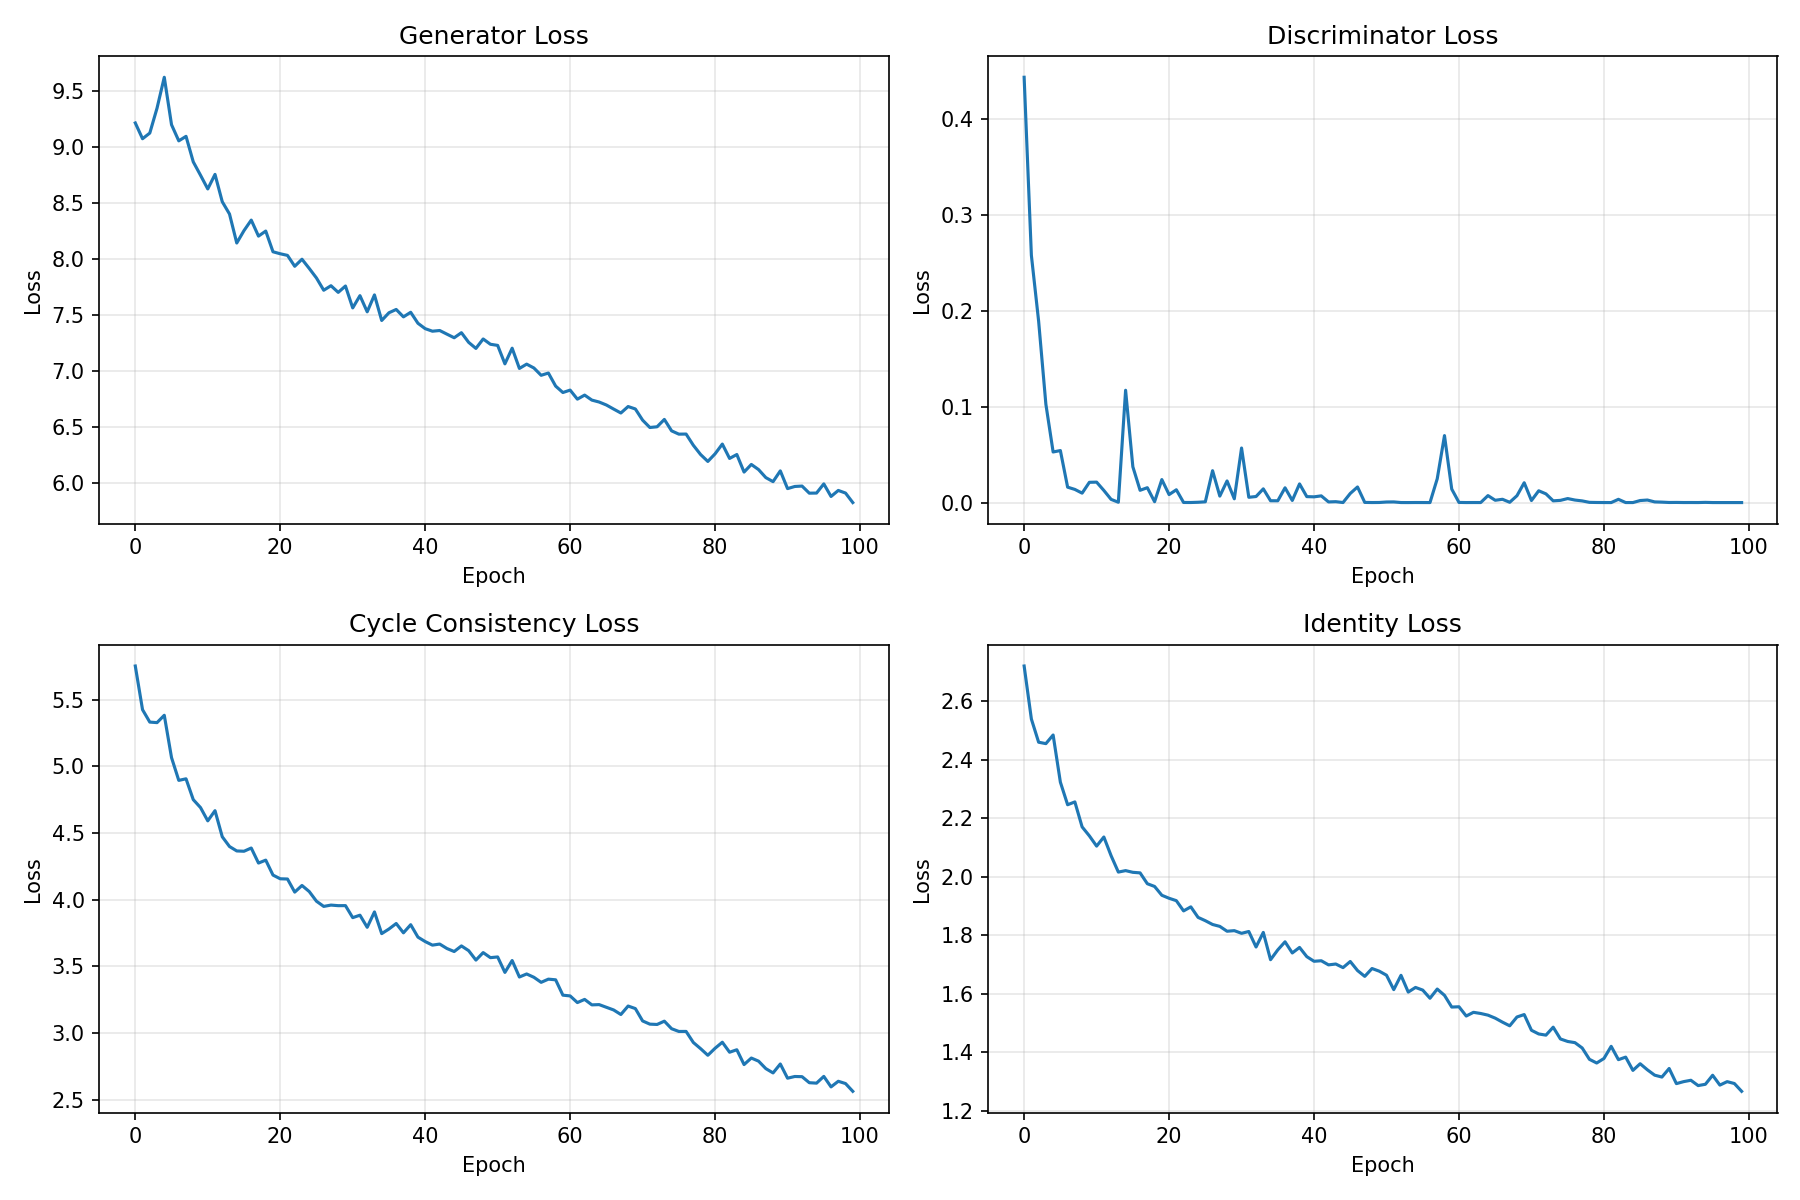

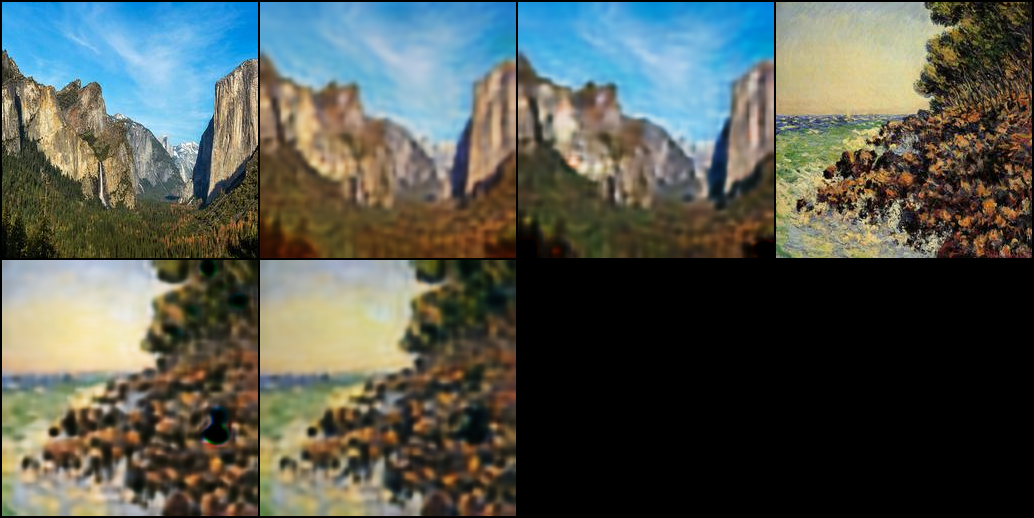

## Original Disgriminator + Dropout

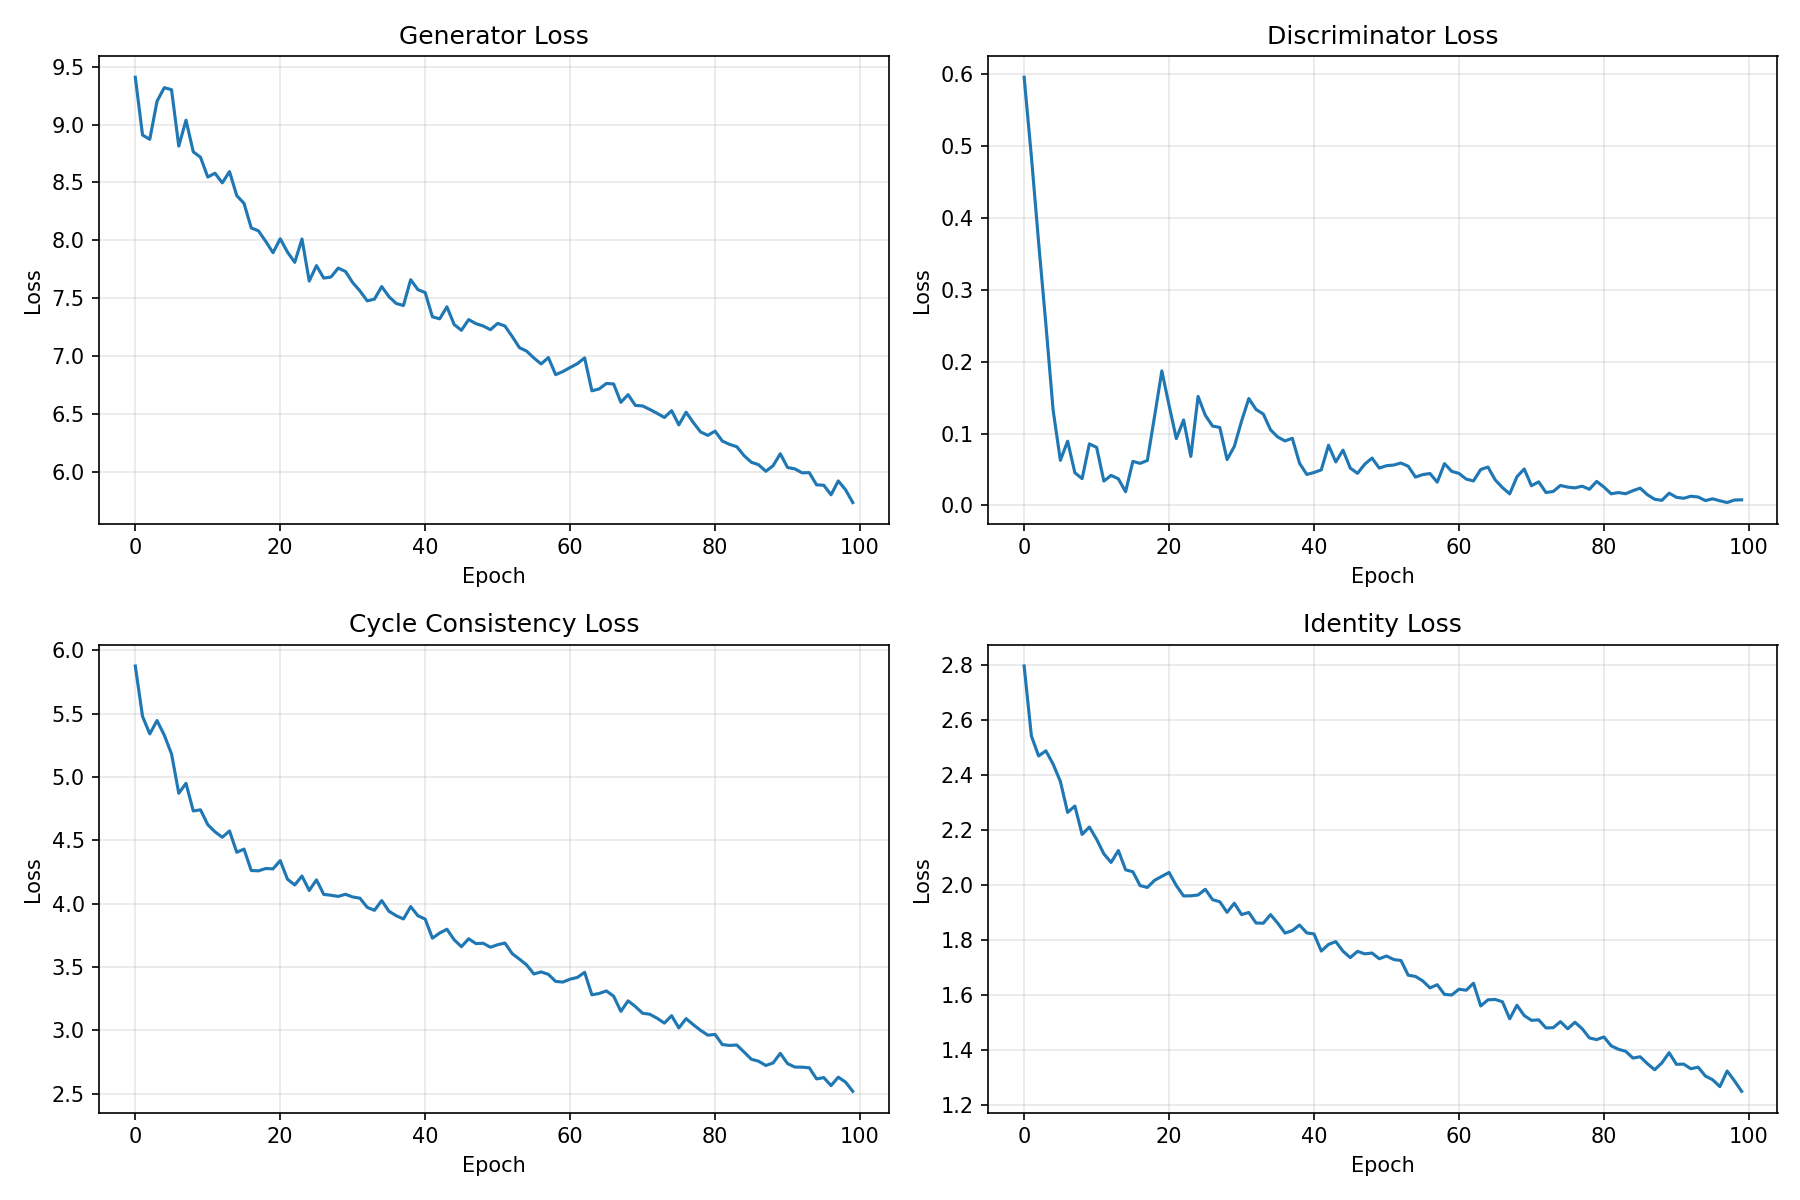

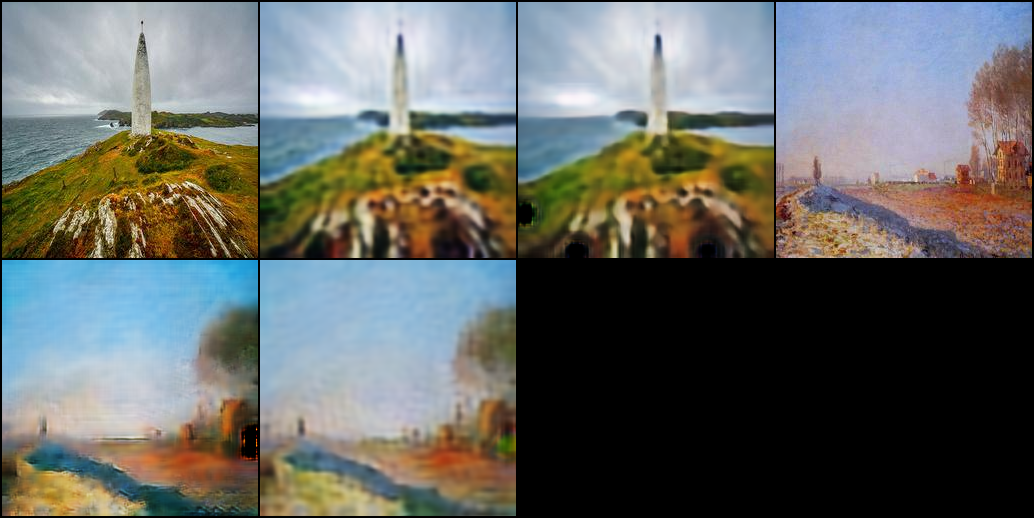

## Original Discriminator - Layer

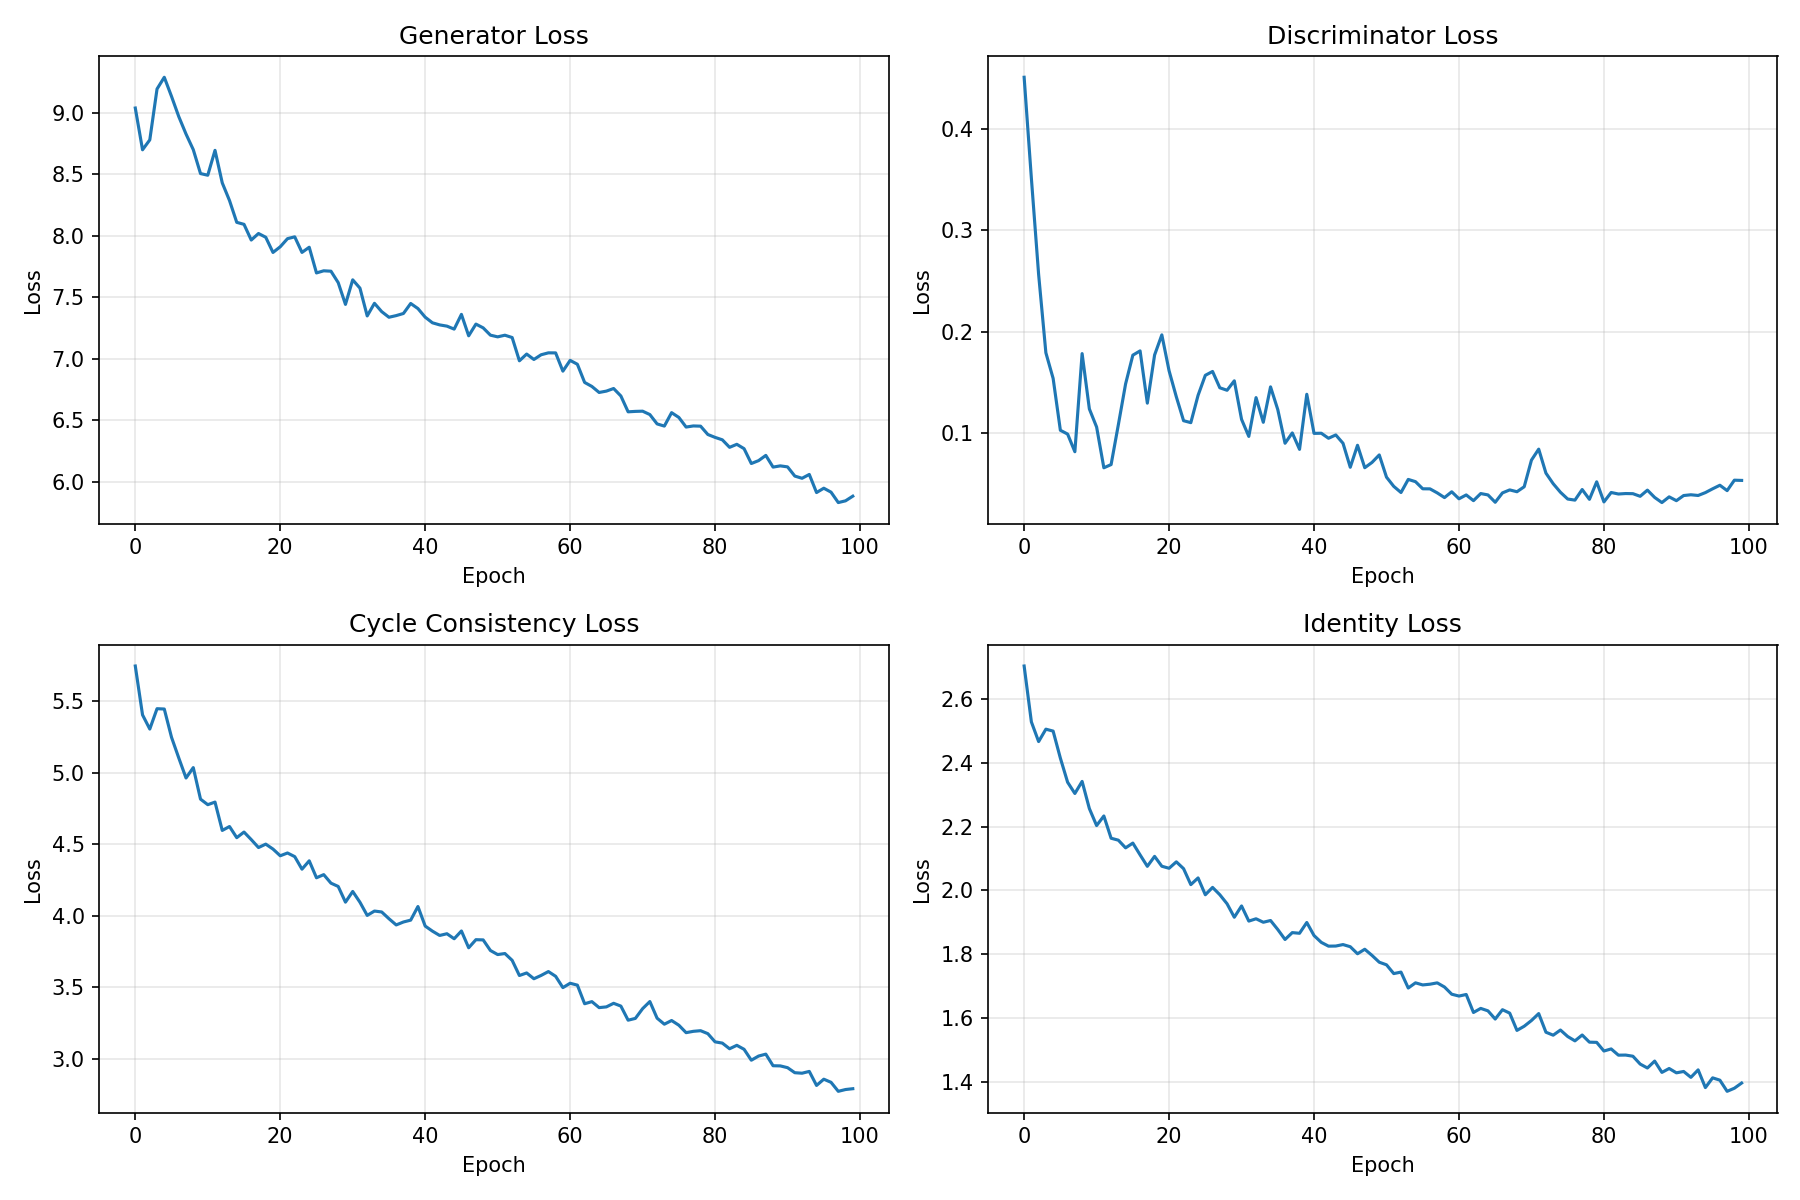

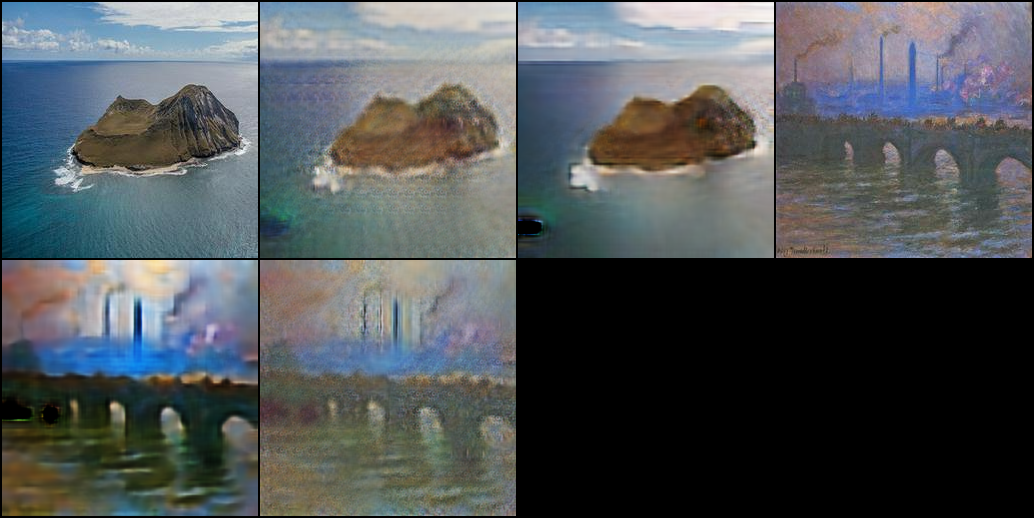

## Weak Discriminator (- Layer + Dropout)

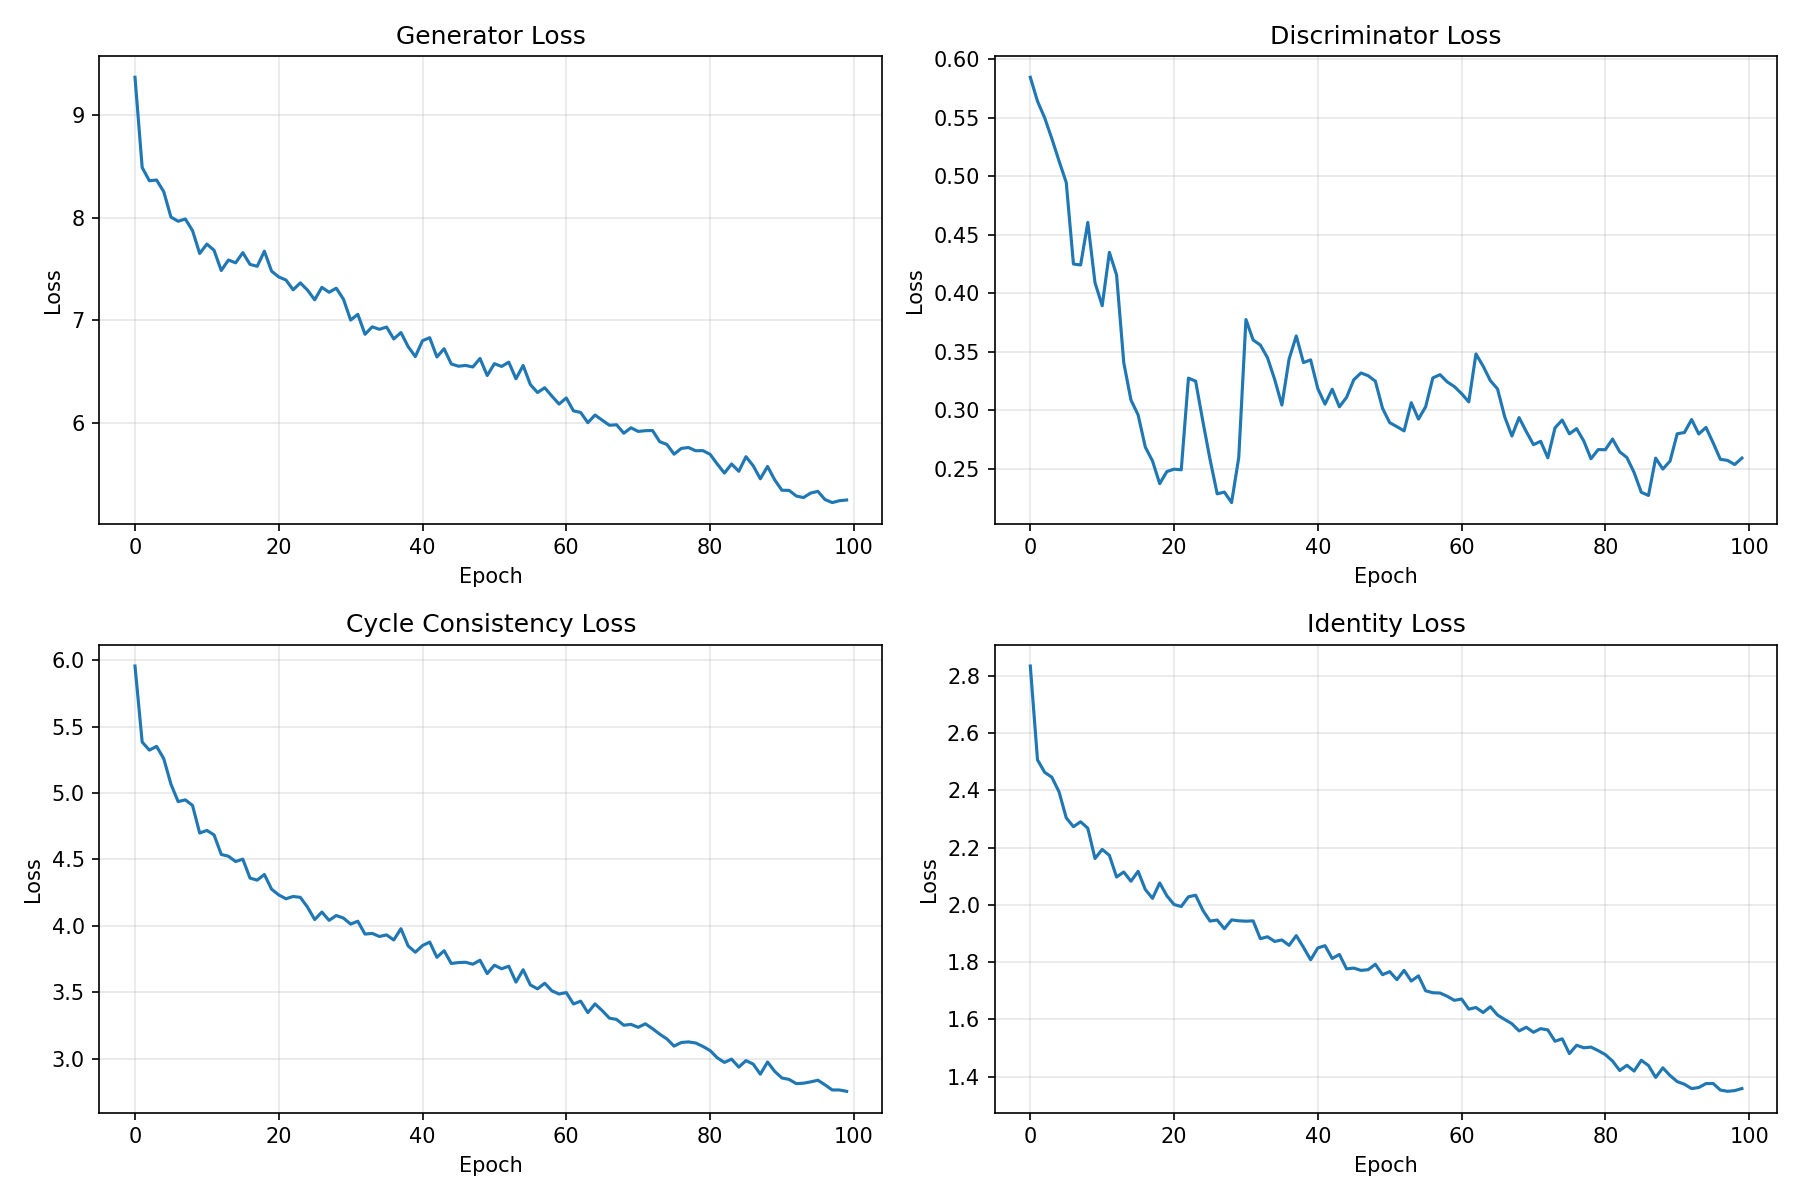

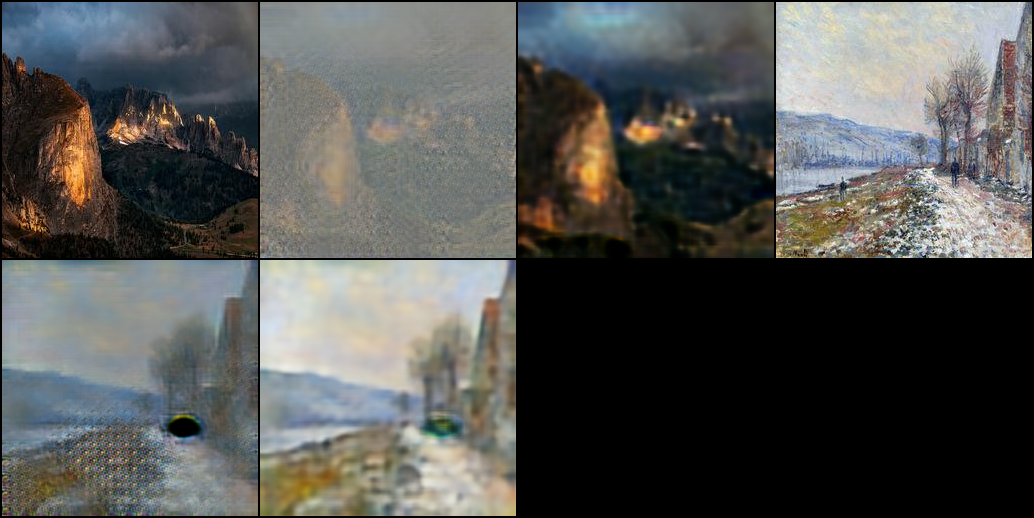

From the results, we can see that even though the generator loss is lower for the weak discriminator model, it did not result in the best generated images, as it produced a fog like filter for its images. The discriminator loss fluctuates more as it is weakened, which makes sense as it is fighting the generator. The loss oscillates at an equilibrium point since the generator improves and the task gets harder, while the generator continues to improve by taking in cycle and identity loss. 

It is also clear that a weak discriminator does not help the generator, as it started learning an exploit to trick the discriminator. A balance is needed between the generator and discriminator for the best results. 

# Conclusion

In conclusion, CycleGANs, or cycle generative adversarial networks, are tricky to train as a good balance between generator and discriminator strength is needed. Future improvements for this model would involve tuning the strength of the discriminator a bit more, as even with the best performing model having the discriminator with less layers, the discriminator loss still gets very low and may not be giving much feedback to the generator. 

# References

Kaggle Notebook by Nikki Rani - https://www.kaggle.com/code/raninikki/painter-gans